In [113]:
import random
import gensim
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict


In [114]:
year='2023'
papers=pd.read_csv(f'/Users/naphat-c/Documents/naphat/Data/project/CEDT-DS-Project_LittleMermaid/ExtractedData/{year}.csv')

In [115]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

In [116]:
papers.head()

,Title,Abstract,Author,Aggregation_Type,Publisher,Publication_Date,Institutions,Keywords,Filename
0,Graphene oxide-alginate hydrogel-based indicat...,© 2023 Elsevier B.V.Pyrocatechol violet/copper...,Boobphahom S.; Rodthongkum N.,Journal,Elsevier B.V.,2023-12-31,Chulalongkorn University; Mahidol University; ...,Alzheimer's disease; Hydrogel colorimetric sen...,202300000
1,Rare coordination behavior of triethanolamine ...,"© 2023 Elsevier B.V.Herein, unusual and rare c...",Chauhan C.; Kumar R.; Saini A.; Kumar R.; Kuma...,Journal,Elsevier B.V.,2023-12-15,Himachal Pradesh University; Punjabi Universit...,Copper(II); Hirshfeld calculations; Molecular ...,202300001
2,Total ammonia nitrogen removal and microbial c...,© 2023 Elsevier B.V.This study assessed the ch...,Satanwat P.; Tapaneeyaworawong P.; Wechprasit ...,Journal,Elsevier B.V.,2023-12-15,National Science and Technology Development Ag...,Ammonia removal; Carrying capacity; Microbiome...,202300002
3,Effects of microaeration and sludge recirculat...,© 2023 Elsevier B.V.A novel anaerobic baffled ...,Buakaew T.; Ratanatamskul C.,Journal,Elsevier B.V.,2023-12-10,Chulalongkorn University; Chulalongkorn Univer...,Anaerobic baffled biofilm–MBR (AnBB-MBR); Memb...,202300003
4,Bioaccumulation of heavy metals in commerciall...,© 2023 Elsevier B.V.Safety of aquatic products...,Patchaiyappan A.; Arulkumar A.; Shynshiang K.;...,Journal,Elsevier B.V.,2023-12-10,French Institute of Pondicherry; Achariya Arts...,Contamination; Health risk assessment; Heavy m...,202300004


In [117]:
papers['Abstract'][4]

'© 2023 Elsevier B.V.Safety of aquatic products is one of the important public health concerns globally, mainly in developing countries with culture and capture fisheries. In the present study, the bioaccumulation of heavy metals such as Cu, Zn, Cr, Pb, As and Cd in the muscle tissues of crustaceans, molluscs and finfishes collected from the Pondicherry (Puducherry) coast were determined using inductively coupled plasma mass spectrometry (ICP-MS). Among the analysed organisms, maximum concentration of Cu (26.1 ±0.83μg/g) was observed in Perna viridis, Zn (25.03 ±0.82μg/g) in Charybdis feriata, 1.33 ±0.04μg/g of Cr in Atule mate, 1.48 ±1.05μg/g of Pb in Sardinella fimbriata, 2.88±2.16μg/g of Cd in Nemipterus jopanicus and 0.72 ±0.15μg/ g of As in Decapterus russelii. Among the various marine organisms studied, the benthic species showed higher metal accumulation than the pelagic species. The heavy metal accumulation level differed significantly between the organisms. The elemental level

In [118]:
print(len(papers))

2890


In [119]:
texts = []
for i in range(len(papers)):
    title = str(papers['Title'][i]) if not pd.isna(papers['Title'][i]) else ''
    abstract = str(papers['Abstract'][i]) if not pd.isna(papers['Abstract'][i]) else ''
    text = title + ' ' + abstract
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

print(texts[0])

['graphene', 'oxide', 'alginate', 'hydrogel', 'based', 'indicator', 'displacement', 'assay', 'integrated', 'with', 'diaper', 'for', 'non', 'invasive', 'alzheimer', 's', 'disease', 'screening', '2023', 'elsevier', 'b', 'v', 'pyrocatechol', 'violet', 'copper', 'ion', 'graphene', 'oxide', 'alginate', 'pv', 'cu2', 'go', 'alg', 'hydrogel', 'was', 'fabricated', 'and', 'applied', 'as', 'a', 'colorimetric', 'sensor', 'for', 'monitoring', 'urinary', 'cysteine', 'via', 'an', 'indicator', 'displacement', 'assay', 'ida', 'and', 'cu2', 'cysteine', 'affinity', 'pair', 'the', 'hydrogel', 'based', 'sensor', 'was', 'formed', 'by', 'ca2', 'cations', 'cross', 'linked', 'pv', 'cu2', 'go', 'alg', 'the', 'morphologies', 'of', 'hydrogel', 'were', 'characterized', 'by', 'field', 'emission', 'scanning', 'electron', 'microscopy', 'with', 'energy', 'dispersive', 'x', 'ray', 'spectroscopy', 'and', 'fourier', 'transform', 'raman', 'spectroscopy', 'incorporating', 'go', 'into', 'the', 'hydrogel', 'improved', 'its',

In [120]:
import logging
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 152 stopwords
loaded 42 bigrams
loaded 2 stem rules


In [121]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))

Top words


,word,count,in stopwords.txt?
0,the,36653,Yes
1,and,25518,Yes
2,of,24765,Yes
3,in,14759,Yes
4,to,12269,Yes
5,a,10297,
6,with,7182,Yes
7,for,6850,Yes
8,were,4875,Yes
9,was,4866,Yes


In [122]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(p, 0)",831,
1,"(author, s)",639,
2,"(95, ci)",449,
3,"(covid, 19)",432,
4,"(2023, elsevier)",306,
5,"(rights, reserved)",293,
6,"(0, 05)",246,
7,"(0, 001)",212,
8,"(cov, 2)",200,
9,"(sars, cov)",196,


In [123]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [124]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [125]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

,Original,Stem,Unstem,Count
0,study,studi,study,2545
1,patients,patient,patients,1718
2,analysis,analysi,analysis,1361
3,group,group,group,1053
4,data,data,data,1008
5,treatment,treatment,treatment,915
6,thailand,thailand,thailand,884
7,model,model,model,878
8,after,after,after,815
9,showed,show,showed,809


In [126]:
# Remove papers with less than 25 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 25]
papers = papers.iloc[indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 2797 (removed 93)


In [127]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

papers: 2797
dictionary size: 5218


In [128]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq

In [129]:
num_topics = 12
seed = 7

tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

violation: 1.0
violation: 0.2387823143990132
violation: 0.1682116062034569
violation: 0.12845478104696706
violation: 0.09814329882116309
violation: 0.07302209381368481
violation: 0.05512474943385129
violation: 0.04304592250813479
violation: 0.03480105372924787
violation: 0.02826665083829181
violation: 0.022949155271048304
violation: 0.018640990769180722
violation: 0.015243734040447881
violation: 0.012509038518017566
violation: 0.01033106291950759
violation: 0.008611774437203368
violation: 0.007252839174207798
violation: 0.006175074958553551
violation: 0.005327660624646574
violation: 0.004688605852681929
violation: 0.0041843633342892915
violation: 0.0037950837213662856
violation: 0.0034606765391603776
violation: 0.003181312588400172
violation: 0.0029417367897813375
violation: 0.0027331911300419215
violation: 0.0025477139276550618
violation: 0.0023796000653669765
violation: 0.0022279529744959558
violation: 0.0020879841177667384
violation: 0.0019543532002548668
violation: 0.00183022134397

In [130]:
rows = []
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,patients (0.024),group (0.0099),outcomes (0.0077),ci (0.0072),clinical (0.007),treatment (0.0066),associated (0.0056),risk (0.0051),score (0.0046),trial (0.0046)
1,B,composite (0.0073),properties (0.0073),surface (0.0064),materials (0.0063),strength (0.0051),zn (0.0046),fiber (0.0046),mechanical (0.0044),coated (0.0042),adsorption (0.0042)
2,C,cell (0.035),cancer (0.011),expression (0.01),induced (0.008),protein (0.0078),gene (0.0059),lung (0.0051),pathway (0.0049),il (0.0046),apoptosis (0.0044)
3,D,sustainable (0.0068),management (0.006),research (0.0058),review (0.0057),development (0.0055),production (0.0054),system (0.0047),design (0.0045),social (0.0042),process (0.0039)
4,E,vaccine (0.068),covid (0.023),dose (0.021),cov (0.017),sars (0.017),infection (0.014),immune (0.013),antibody (0.011),omicron (0.011),bnt162b2 (0.01)
5,F,species (0.023),strain (0.018),sp (0.014),nov (0.013),isolated (0.012),gene (0.0098),genus (0.0094),thailand (0.0088),sequencing (0.0079),genome (0.0077)
6,G,detection (0.027),sensor (0.018),cov (0.011),sars (0.011),electrochemical (0.01),samples (0.01),device (0.01),sensitivity (0.01),fluorescence (0.0075),ion (0.0065)
7,H,extract (0.039),activity (0.02),antioxidant (0.017),compounds (0.016),ml (0.011),anti (0.01),against (0.01),ic50 (0.0084),plant (0.0074),mg (0.0069)
8,I,proton (0.041),boson (0.025),collisions (0.023),decay (0.021),tev (0.017),search (0.017),lepton (0.016),jets (0.015),quark (0.014),higgs (0.014)
9,J,catalyst (0.029),co2 (0.014),acid (0.014),production (0.012),reaction (0.011),carbon (0.011),hydrogen (0.01),catalytic (0.0088),oil (0.0074),temperature (0.0073)


Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


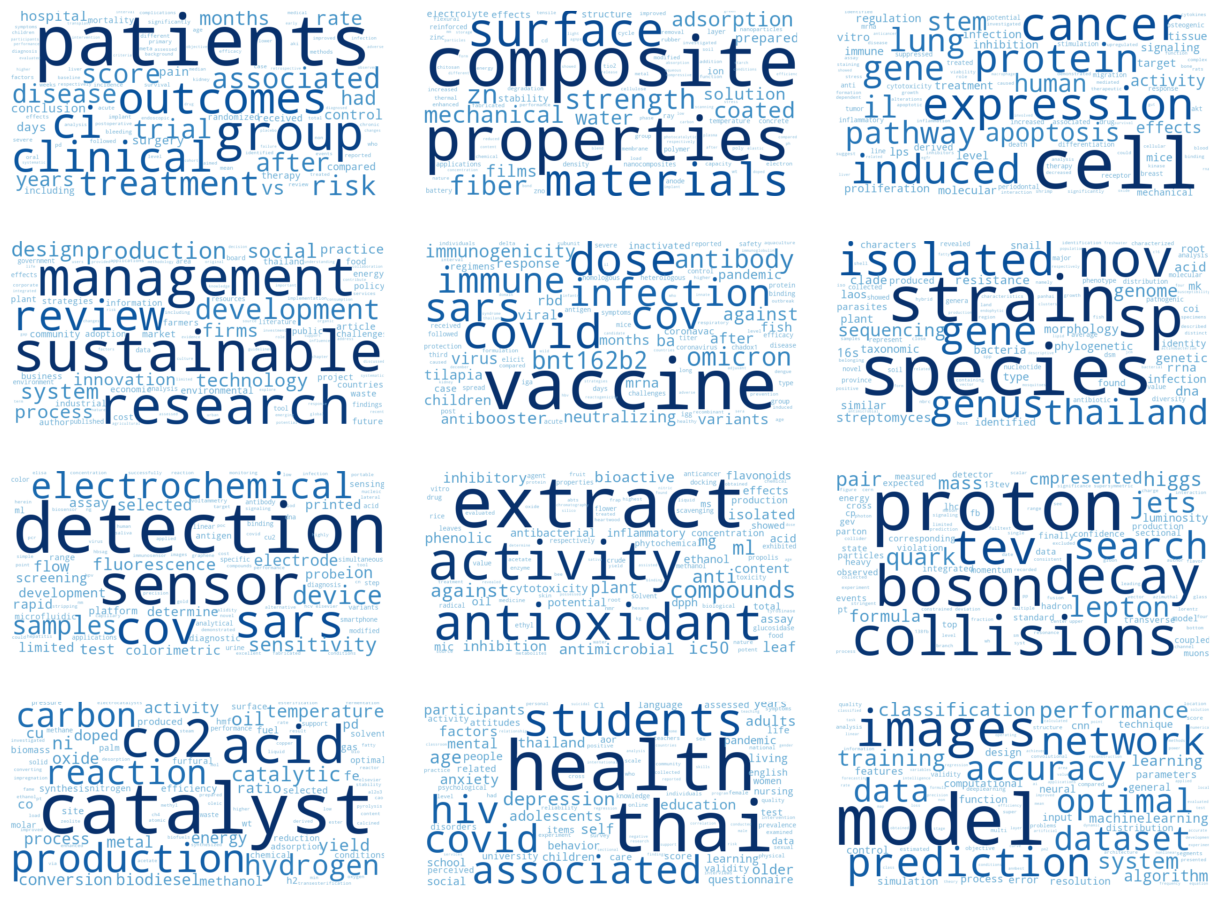

In [131]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2797 samples in 0.000s...
[t-SNE] Computed neighbors for 2797 samples in 0.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2797
[t-SNE] Computed conditional probabilities for sample 2000 / 2797
[t-SNE] Computed conditional probabilities for sample 2797 / 2797
[t-SNE] Mean sigma: 0.022740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.408470
[t-SNE] KL divergence after 1000 iterations: 1.303626


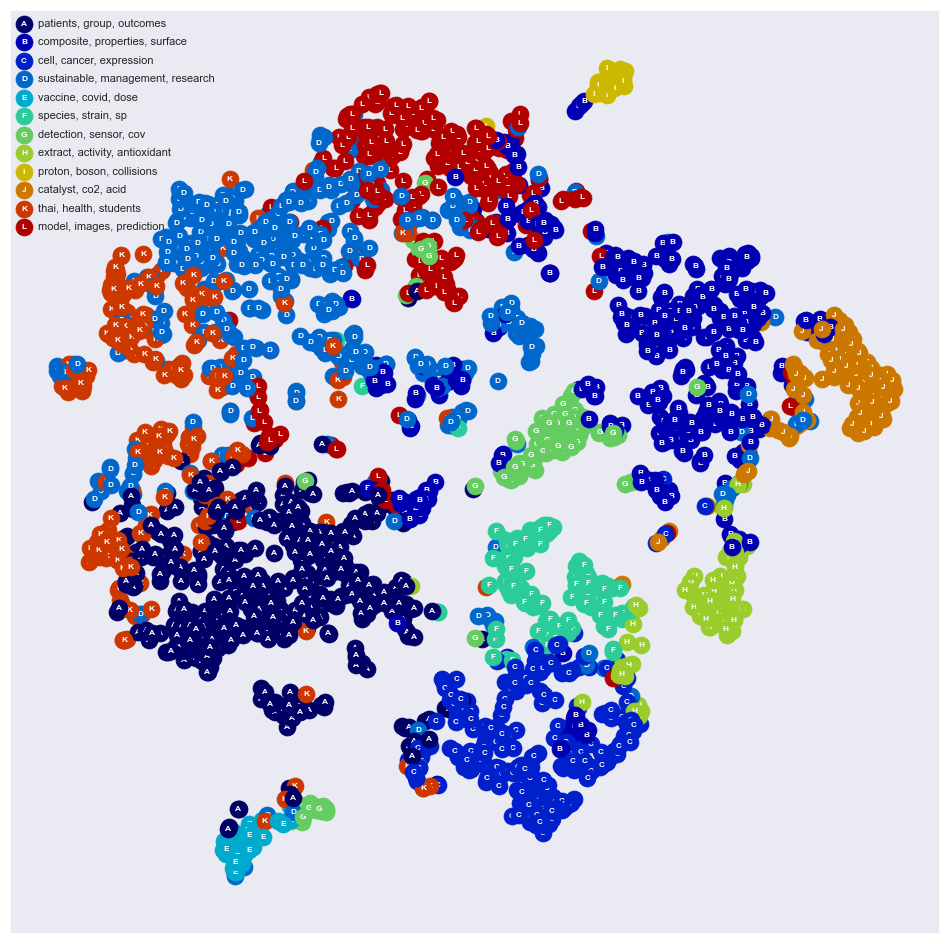

In [132]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD
vis_seed = 6
vis_angle = 135

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

In [133]:
def on_select(i):
    i=i-1
    p = papers.iloc[i]
    print(p['Title'])
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    fig = prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p['Abstract'])

options = sorted([((str(p['Title']) or '').strip()[:50], i) for i, p in papers.iterrows()])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
display(widget)

interactive(children=(Dropdown(description='i', options=(('0.01 Cent per Second: Developing a Cloud-based Cos'…